In [ ]:
!pip install -q -U google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.3/196.3 kB 10.4 MB/s eta 0:00:00


In [ ]:
import argparse
from google import genai
from google.genai import types
import pandas as pd
import time
from sklearn.metrics import f1_score
import re
import json
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
def get_prediction(claim, reference, model_name):
    prompt_prefix = """
    You are an annotator concerned that the claim may not align with the reference.
    Your task is to determine whether the reference entail, contradict, or is unverifiable to the claim.
    You will be given two inputs: claim, reference.
    A reference entails a claim if the information in the reference directly supports the claim being true and there is no conflicting information. The information logically leads to the claim being correct.
    A reference contradicts a claim if it provides information that directly disproves or disagrees with any part of the claim. This includes stating different entities, numeric values, or relations compared to the claim.
    A reference is unverifiable to a claim if it does not provide enough information to determine whether the claim is true or false. This happens if the reference is unrelated, missing key details, or too ambiguous.
    Example:
    ##
    claim: Microstructured Waveguide Biosensors: Applications: Analysis of various beverages like water, tea, coffee, wine, and strong drinks, which suggests they could be used for all types of liquids without limitations [9].
    reference: [9]: The microstructured waveguide biosensor is described. The biosensor was tested in experiments for analysis of water, tea, coffee, wine and strong drinks. The biosensor has a high sensitivity to the optical properties of a medium, filling up the waveguide's core. The small size, good integration ability and compatibility for use in industrial settings make such biosensor very promising for various applications, including food industry.
    justification: Justification 1: The claim is consistent with the information provided in the reference.\nJustification 2: Both the reference and the claim discuss the biosensor's application in analyzing various beverages.
    answer: Entailment
    ##
    claim: Fetal and Neonatal Outcomes: Lethal Forms: While some forms of OI are lethal, it is often assumed that all cases with severe skeletal deformities detected via prenatal imaging will lead to therapeutic abortion being recommended [5].
    reference: [5]: Osteogenesis imperfecta (OI) is a heterogeneous group of diseases affecting type I collagen and characterized by bone fragility. Lethal forms are rare and are characterized by micromelia associated with limb deformities. We report two cases of prenatally diagnosed lethal OI. Patients underwent ultrasound examination at 17 and 25 weeks of amenorrhoea, supplemented with fetal skeletal CT scanning in one case. Therapeutic abortion was recommended in both cases.
    justification: Overstatement of the claim by stating all cases with severe skeletal deformities detected via prenatal imaging will lead to therapeutic abortion as the reference only presented 2 cases.
    answer: Contradiction
    ##
    claim: Specialized Procedures: Esophagectomy and Gastric Resection: These are now minimally invasive procedures for upper gastrointestinal cancers, with endoscopic techniques being more suitable for advanced-stage cancers [5].
    reference:  [5]: Despite advances in minimally invasive surgery, esophagectomy, and gastric resection remain morbid procedures for cancers of the upper gastrointestinal tract. Endoscopy offers patients effective screening and treatment of early-stage cancers. Endoscopic mucosal resection (EMR) can effectively remove benign and early malignant lesions. This chapter will focus on the use of EMR in the upper digestive tract.
    justification: Justification 1: The claim focused on endoscopic procedure for advanced stage cnacers while the reference focused on endoscopic procedure for early stage cancer.\nJustification 2: Related: The first part of the claim that there are now minimally invasive procedures for upper gastrointestinal cancers is true, however, the second part which states "with endoscopic techniques being more suitable for advanced-stage cancers" is not mentioned in the reference per se.
    answer: Unverifiable
    ##
    Input:
    """

    client = genai.Client(api_key="")

    config = types.GenerateContentConfig(
        temperature=0,
        seed = 13
    )

    full_prompt = f"""
    {prompt_prefix}
    claim: {claim}
    reference: {reference}
    Your response only answer 'Entailment' or 'Contradiction' or 'Unverifiable'
    answer:
    """
    try:
        response = client.models.generate_content(
            model=model_name,
            contents=full_prompt,
            config=config
        )
        return response.text.strip()
    except Exception as e:
        print(f"Error: {e}")
        return None

def main(output_path, sleep_time, model_name):
    df = pd.read_csv('/content/df_1.csv')

    predictions = []

    for idx, row in df.iterrows():
        claim = row['claim_clean']
        reference = row['reference_clean']
        prediction = get_prediction(claim, reference, model_name)
        predictions.append(prediction)

        if (idx + 1) % 10 == 0:
            print(f"Processed {idx + 1}...")

        time.sleep(sleep_time)

    df['predict'] = predictions

    df.to_csv(output_path, index=False)

In [ ]:
main("gem.csv", 0.42, 'gemini-2.5-pro-preview-05-06')

Processed 10...
Processed 20...
Processed 30...
Processed 40...
Processed 50...
Processed 60...
Processed 70...
Processed 80...
Processed 90...
Processed 100...
Processed 110...
Processed 120...
Processed 130...
Processed 140...
Processed 150...
Processed 160...
Processed 170...
Processed 180...
Processed 190...
Processed 200...
Error: 'NoneType' object has no attribute 'strip'
Processed 210...
Processed 220...
Processed 230...
Processed 240...
Processed 250...
Processed 260...
Processed 270...
Processed 280...
Processed 290...
Processed 300...
Processed 310...
Processed 320...
Processed 330...
Processed 340...
Processed 350...
Processed 360...
Processed 370...
Processed 380...
Error: 'NoneType' object has no attribute 'strip'
Processed 390...
Processed 400...
Processed 410...
Processed 420...
Processed 430...
Processed 440...
Processed 450...
Processed 460...
Processed 470...
Processed 480...
Processed 490...
Processed 500...


In [ ]:
labels = ['Contradiction', 'Entailment', 'Unverifiable']
#labels = ['Opposite meaning','Misrepresentation','Related but unverifiable','Entailment','Entity error','Unrelated and unverifiable','Numeric error','Missing information']
df = pd.read_csv('/content/gem.csv')
df = df.dropna()
# Hàm xử lý từng dòng
def extract_label(text):
    found = [label for label in labels if label in text]
    if len(found) == 1:
        return found[0]
    else:
        return 'MULTI_OR_NONE'  # đánh dấu các mẫu không rõ ràng

# Áp dụng hàm
df['predict'] = df['predict'].apply(extract_label)
df_ambiguous = df[df['predict'] == 'MULTI_OR_NONE']
print(len(df_ambiguous) == 0)
print(set(df['label']) == set(df['predict']))
print(len(df))

True
True
498


In [ ]:
df = pd.read_csv('gem2_3.csv')
df = df[df['predict'].isin(['Contradiction', 'Entailment', 'Unverifiable'])]
df['predict'].unique()

array(['Contradiction', 'Entailment', 'Unverifiable'], dtype=object)

In [ ]:
df = pd.read_csv('gem.csv')
df = df[df['predict'].isin(['Opposite meaning', 'Misrepresentation', 'Related but unverifiable', 'Entailment', 'Entity error', 'Unrelated and unverifiable', 'Numeric error', 'Missing information'])]
df['predict'].unique()

array(['Misrepresentation', 'Related but unverifiable',
       'Missing information', 'Unrelated and unverifiable',
       'Opposite meaning', 'Entailment', 'Numeric error', 'Entity error'],
      dtype=object)

In [ ]:
macro_f1 = f1_score(df['label'], df['predict'], average='macro')
print("Macro F1 Score:", macro_f1)

Macro F1 Score: 0.541985000308047


Macro F1-score: 0.530458287707331


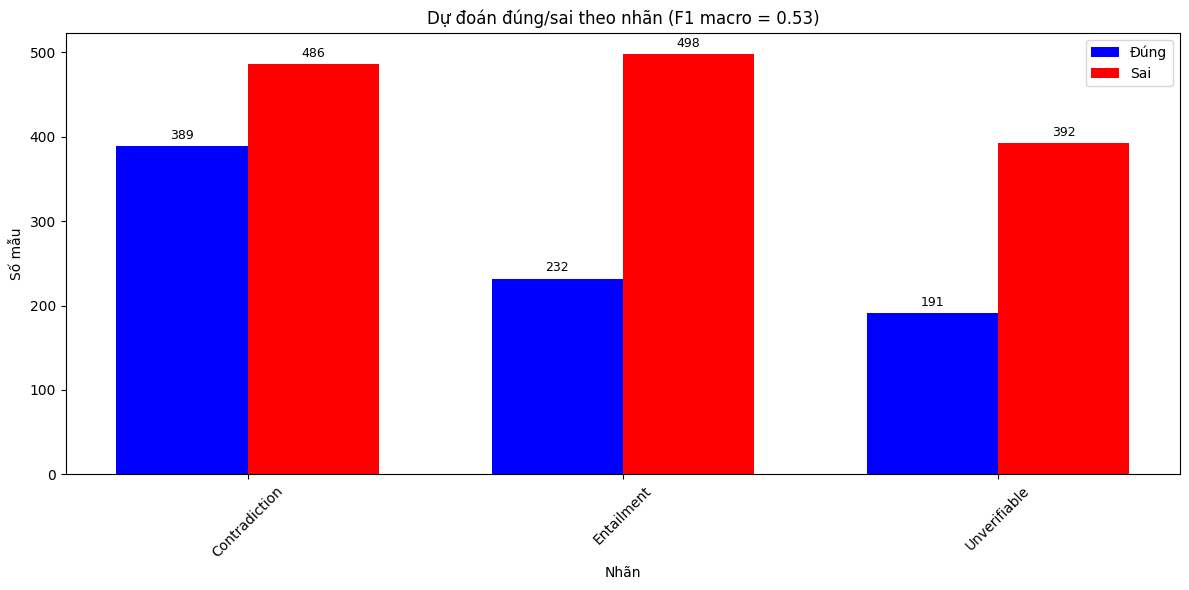

In [ ]:
mapping = {
    'Entailment': 'Entailment',
    'Related but unverifiable': 'Unverifiable',
    'Unrelated and unverifiable': 'Unverifiable',
    'Opposite meaning': 'Contradiction',
    'Missing information': 'Contradiction',
    'Entity error': 'Contradiction',
    'Misrepresentation': 'Contradiction',
    'Numeric error': 'Contradiction'
}

# Áp dụng mapping vào cột 'predict'
df['predict'] = df['predict'].map(mapping)

f1 = f1_score(df['label'], df['predict'], average='macro')
print("Macro F1-score:", f1)
labels = sorted(df['label'].unique())  # đảm bảo sắp xếp để hiển thị gọn
correct_counts = []
incorrect_counts = []

for label in labels:
    # Số lần dự đoán đúng cho nhãn này
    correct = ((df['label'] == label) & (df['predict'] == label)).sum()
    # Số lần dự đoán sai mà thực tế là nhãn này hoặc dự đoán thành nhãn này
    incorrect = ((df['label'] == label) & (df['predict'] != label)).sum() + \
                ((df['label'] != label) & (df['predict'] == label)).sum()

    correct_counts.append(correct)
    incorrect_counts.append(incorrect)

x = np.arange(len(labels))  # vị trí của nhãn
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, correct_counts, width, label='Đúng', color='blue')
bars2 = ax.bar(x + width/2, incorrect_counts, width, label='Sai', color='red')

ax.set_xlabel('Nhãn')
ax.set_ylabel('Số mẫu')
ax.set_title(f'Dự đoán đúng/sai theo nhãn (F1 macro = {f1:.2f})')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.tick_params(axis='x', labelrotation=45)
ax.legend()

# 🔢 Ghi số lên cột
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # khoảng cách so với đầu cột
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig("ten_file.png")
plt.show()